In [192]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from tqdm import tqdm



data_dir =Path('/common/home/vk405/Projects/EnergyLab/Solar-forcast/Data/')

In [61]:
#load data
#contains meteroligical readings data

files = os.listdir(data_dir)


def combine_dfs(data_dir,date_start='2012-01-01',date_end='2017-11-30',save=False):
    to_combine = []
    files = os.listdir(data_dir)
    for file in files:
        df1 = pd.read_csv(data_dir/file).dropna()
        df1.columns.values[[0,2]] = ['Date','GHI']
        to_combine.append(df1.iloc[:,[0,1,2]])
    df_combine = pd.concat(to_combine,axis=0)
    df_combine['Date'] = pd.to_datetime(df_combine['Date'])
    mask = (df_combine['Date'] >= datetime.strptime(str(date_start), '%Y-%m-%d')) & (df_combine['Date'] <= datetime.strptime(
                str(date_end), '%Y-%m-%d'))
    df_final = df_combine.loc[mask]
    if save:
        df_final.to_csv(os.path.join(data_dir, 'SRRL_measurement_timeseries.csv'), index=False)
    return df_final


#df = combine_dfs(data_dir,save=True)



In [62]:
df_svd = pd.read_csv(os.path.join(data_dir, 'SRRL_measurement_timeseries.csv'))

In [63]:
df_svd['GHI'].describe()

count    4.733763e+06
mean     3.835746e+02
std      4.567181e+02
min     -9.999900e+04
25%      1.177000e+02
50%      3.157340e+02
75%      6.040190e+02
max      1.587360e+03
Name: GHI, dtype: float64

In [64]:
trn_df = df_svd.loc[pd.to_datetime(df_svd['Date']).dt.year <= 2014]
rst_df = df_svd.loc[pd.to_datetime(df_svd['Date']).dt.year > 2014]

In [65]:
trn_df.describe()

,GHI
count,2.392920e+06
mean,3.842849e+02
std,4.951455e+02
min,-9.999900e+04
25%,1.206100e+02
50%,3.176300e+02
75%,6.048805e+02
max,1.587360e+03


In [66]:
rst_df.describe()

,GHI
count,2.340843e+06
mean,3.828484e+02
std,4.137622e+02
min,-9.999900e+04
25%,1.148200e+02
50%,3.136970e+02
75%,6.031500e+02
max,1.488480e+03


As used by [authors](https://www.sciencedirect.com/science/article/pii/S0306261921016639#b47)

trn = 2012-01-01 to 2014-12-31

vld = 2015-01-01 to 2015-12-31

tst = 2016-01-01 to 2017-12-31

Preprocessing for image

In [67]:
# Image-data

date_start='2012-01-01'
date_end='2017-11-30'
image_dir = Path('/common/users/vk405/EnergyLab/Data')

In [68]:
%matplotlib inline

smpl_img = image_dir/'20150605'/'20150605072000.raw.jpg'
image = mpimg.imread(smpl_img)
image.shape

(352, 288, 3)

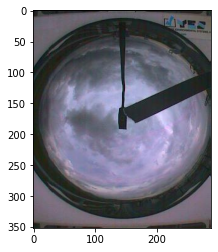

In [69]:
plt.imshow(image)

In [70]:
image.shape

(352, 288, 3)

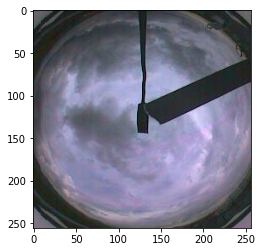

In [71]:
plt.imshow(image[48:352-48,16:288-16,:])

In [72]:
crpd_img = image[48:352-48,16:288-16,:]

In [73]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [74]:
mask = create_circular_mask(256,256)

In [75]:
out = crpd_img*np.expand_dims(mask,axis=2)
out.shape

(256, 256, 3)

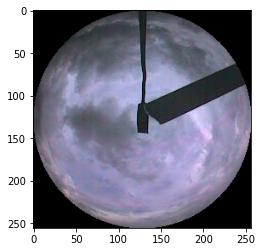

In [76]:
plt.imshow(out)

In [77]:
out.shape

(256, 256, 3)

We Daytime readings from 7:25 to 16:45

So below we will

- Generate targets btw 7:30,4:30 everyday.(next ten minute average)
- Based on lookback generate and store corresponding cropped images

In [229]:

def get_targets(df_svd):
    start = datetime.fromisoformat("2012-01-01 07:30")
    end = datetime.fromisoformat("2012-01-01 16:40")
    sampl = pandas.date_range('2012-01-01','2012-01-02',freq='min')
    time_strs = set()

    for s_time in sampl:
        if s_time.time() >= start.time() and s_time.time() <= end.time():
            time_strs.add(s_time.time().strftime("%H:%M"))

    # for getting target times
    start = datetime.fromisoformat("2012-01-01 07:30")
    end = datetime.fromisoformat("2012-01-01 16:30")
    spaced_sampl = pandas.date_range('2012-01-01','2012-01-02',freq='10min')
    time_strs_spaced = set()
    for s_time in spaced_sampl:
        if s_time.time() >= start.time() and s_time.time() <= end.time():
            time_strs_spaced.add(s_time.time().strftime("%H:%M"))


    df_fltrd = df_svd[df_svd['MST'].isin(time_strs)].reset_index(drop=True)

    df_fltrd['roll_GHI'] = df_fltrd['GHI'].rolling(10).mean().shift(-10)

    final = df_fltrd[df_fltrd['MST'].isin(time_strs_spaced)].dropna().reset_index(drop=True)
    f = final[['Date','MST','GHI','roll_GHI']]
    f.columns.values[[3]] = ['Target']
    return f


In [230]:
f = get_targets(df_svd)

In [233]:
f.head()

,Date,MST,GHI,Target
0,2012-01-01,07:30,16.033,18.6734
1,2012-01-01,07:40,20.072,26.5878
2,2012-01-01,07:50,32.264,42.4806
3,2012-01-01,08:00,54.900,68.4412
4,2012-01-01,08:10,77.573,89.9590


## Does the GHI VALUES MAKES SENSE : does the cloudy imgs correspond to low values.

In [241]:
#sanity check

f['GHI'].argmax(),f['GHI'].argmin()

(59142, 17478)

In [242]:
f.iloc[59142]

Date      2014-12-11
MST            10:10
GHI          1587.36
Target      611.4047
Name: 59142, dtype: object

In [243]:
f.iloc[17478]

Date      2012-11-13
MST            14:30
GHI         -99999.0
Target      358.1355
Name: 17478, dtype: object

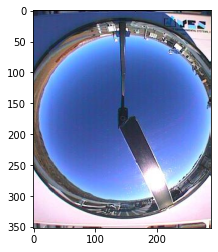

In [244]:
himg = mpimg.imread(image_dir/'20141211'/'20141211101000.raw.jpg')
plt.imshow(himg)

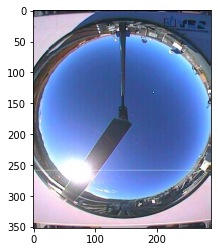

In [245]:
limg = mpimg.imread(image_dir/'20121113'/'20121113143000.raw.jpg')
plt.imshow(limg)

## Seems Not

In [190]:

def get_tgtimgs(image_dir,f):
    all_imgdirs = set(os.listdir(image_dir))
    lookback = 2
    suffix = '.raw.jpg'

    f_ims= []
    f_targets = []
    f_dates = []
    f_times = []
    for ind in tqdm(range(len(f))):
        req_imgs = []
        d_str = f.iloc[ind][0]
        t_str = f.iloc[ind][1]
        tgt = f.iloc[ind][2]
        pres_time = datetime.fromisoformat(' '.join([d_str,t_str]))
        req_imgs.append(pres_time)
        for i in range(lookback-1):
            lst_t = req_imgs[-1]-timedelta(minutes=10)
            req_imgs.append(lst_t)
        presdir = req_imgs[0].strftime("%Y:%m:%d:%H:%M").replace(':','')[:-4]
        reqimg_files = [ele.strftime("%Y:%m:%d:%H:%M").replace(':','')+'00'+suffix for ele in req_imgs]
        
        #print(reqimg_files)
        #print(presdir)
        #print(presdir in all_imgdirs)
        #print(all_imgdirs)
        #print(len(os.listdir(image_dir/presdir)))
        #break
        if presdir in all_imgdirs:
            presdir_imgfiles = set(os.listdir(image_dir/presdir))
            all_fnd = all(ele in presdir_imgfiles for ele in reqimg_files)
            if all_fnd:
                f_targets.append(tgt)
                f_ims.append([image_dir/presdir/ele for ele in reqimg_files])
                f_dates.append(d_str)
                f_times.append(t_str)
        
    d = pd.DataFrame({'Date':f_dates,'MST':f_times,'Imgs':f_ims,'Target':f_targets})
    return d
        

            
        




In [193]:
df_tgtimgs = get_tgtimgs(image_dir,f)

100%|██████████| 308648/308648 [04:31<00:00, 1138.67it/s]


In [213]:
df_tgtimgs.head(2)

,Date,MST,Imgs,Target
0,2012-01-01,07:40,[/common/users/vk405/EnergyLab/Data/20120101/2...,26.5878
1,2012-01-01,07:50,[/common/users/vk405/EnergyLab/Data/20120101/2...,42.4806


In [216]:
df_tgtimgs['Target'].argmax()

267020

In [218]:
df_tgtimgs['Target'].argmin()

16955

In [198]:
#df_tgtimgs.to_csv(data_dir/'tgtimgs.csv',index=False)

In [202]:
#sanity checking

#high target
df_tgtimgs.iloc[4]

Date                                             2012-01-01
MST                                                   08:20
Imgs      [/common/users/vk405/EnergyLab/Data/20120101/2...
Target                                             100.7435
Name: 4, dtype: object

In [204]:
#low target
df_tgtimgs.iloc[0]

Date                                             2012-01-01
MST                                                   07:40
Imgs      [/common/users/vk405/EnergyLab/Data/20120101/2...
Target                                              26.5878
Name: 0, dtype: object

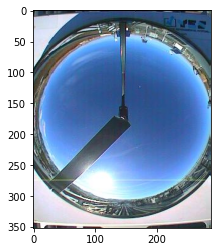

In [217]:
image_high = mpimg.imread(df_tgtimgs.iloc[267020].Imgs[0])
plt.imshow(image_high)

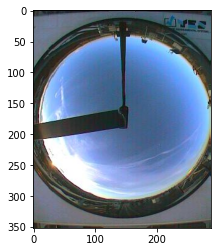

In [219]:
image_low = mpimg.imread(df_tgtimgs.iloc[16955].Imgs[0])
plt.imshow(image_low)

The low value doesn't seem to be that cloudy.

In [225]:
'2015-06-05' 
'07:20'

'07:20'

In [227]:
set(df_tgtimgs['Date'])

{'2012-01-01'}

In [224]:
df_tgtimgs[df_tgtimgs['Date'].isin(set('2015-06-05'))]

,Date,MST,Imgs,Target


In [220]:
df_tgtimgs.iloc[16955].Imgs

[PosixPath('/common/users/vk405/EnergyLab/Data/20120101/20120101162000.raw.jpg'),
 PosixPath('/common/users/vk405/EnergyLab/Data/20120101/20120101161000.raw.jpg')]